In [100]:
import pandas as pd
import numpy as np
import dateutil
from datetime import datetime, timedelta
import pytz
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

# Готовим данные

In [3]:
data = pd.read_csv('2008.csv')

In [4]:
data.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,335,...,4.0,8.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
1,2008,1,3,4,754.0,735,1002.0,1000,WN,3231,...,5.0,10.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2,2008,1,3,4,628.0,620,804.0,750,WN,448,...,3.0,17.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
3,2008,1,3,4,926.0,930,1054.0,1100,WN,1746,...,3.0,7.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,3920,...,3.0,10.0,0,NaN,0,2.0,0.0,0.0,0.0,32.0


In [5]:
data.shape

(7009728, 29)

In [6]:
data.column

Index(['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime',
       'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum', 'TailNum',
       'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay',
       'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut',
       'Cancelled', 'CancellationCode', 'Diverted', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'],
      dtype='object')

In [7]:
data[['Origin', 'Dest']].head()

,Origin,Dest
0,IAD,TPA
1,IAD,TPA
2,IND,BWI
3,IND,BWI
4,IND,BWI


In [12]:
data.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
296865,2008,1,1,2,1.0,1950,228.0,2235,WN,106,...,3.0,7.0,0,NaN,0,151.0,0.0,0.0,0.0,82.0
296940,2008,1,1,2,1.0,2135,117.0,2300,WN,3558,...,5.0,9.0,0,NaN,0,51.0,0.0,0.0,0.0,86.0
346517,2008,1,1,2,2.0,2355,529.0,532,F9,380,...,7.0,8.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
354001,2008,1,1,2,2.0,2255,57.0,2357,FL,579,...,8.0,9.0,0,NaN,0,0.0,0.0,0.0,0.0,60.0
546769,2008,1,1,2,2.0,2355,836.0,755,B6,166,...,8.0,34.0,0,NaN,0,7.0,0.0,34.0,0.0,0.0


In [31]:
data['Month'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

In [32]:
# возьмем данные за один месяц, как сказано в задаче
data_selected = data[data['Month']==1]

## Приводим даты
### Используем таймзоны

In [16]:
# Getting airports' timezone information
airport_tz = pd.read_fwf('https://raw.githubusercontent.com/hroptatyr/dateutils/tzmaps/iata.tzmap', names=['code', 'tz'], colspecs=[(0, 3), (3, None)])
#
# make sure that all airports in our dataset are present
airports = pd.Series(data['Origin'].unique())
codes = airport_tz.code.unique()
bad = [ap not in codes for ap in airports]
for a in airports[bad]:
    print(a)

PFN


In [17]:
# Add time the airport timezone
airport_tz.loc[len(airport_tz.index)] = ['PFN', 'America/Chicago']
# Make code index
airport_tz = airport_tz.set_index('code')
# show tail
airport_tz.tail(2)

,tz
code,
ZZV,America/New_York
PFN,America/Chicago


In [23]:
def to_time(int_var):
    """
    Returns time recorded as integer and format it as time (24h) in string format.
    Examples:
    1 -> 00:01
    41 -> 00:41
    537 -> 05:37
    1714 -> 17:14
    """
    str_var = str(int_var).rjust(4, '0')
    return str_var[:2] + ':' + str_var[2:]

@np.vectorize
def get_tz(code):
    """
    Returns time zone as dateutil.tz.tz.tzfile from airport code
    """
    tz = dateutil.tz.gettz(airport_tz.loc[code, 'tz'])
    return tz

@np.vectorize
def to_datetime(year, month, day, time, tz):
    """
    Returns datatime in UTC
    """
    h, m = time.split(sep=':')
    result = datetime(year, month, day, int(h), int(m), tzinfo=tz).astimezone(pytz.utc)#.replace(tzinfo=None)
    return result
    #return np.datetime64(result)

def preprocess(df):
    
    # replace 24:00 with 23:53
    df.loc[df['CRSArrTime'] >= 2400, 'CRSArrTime'] = 2359
    df.loc[df['CRSDepTime'] >= 2400, 'CRSArrTime'] = 2359
    
    # create column with departure and arrival time as string
    df['arr_time'] = df['CRSArrTime'].apply(to_time)
    df['dep_time'] = df['CRSDepTime'].apply(to_time)
    
    # create datetime columns
    df['arr_datetime'] = to_datetime(df['Year'], df['Month'], df['DayofMonth'], df['arr_time'], get_tz(df['Dest']))
    df['dep_datetime'] = to_datetime(df['Year'], df['Month'], df['DayofMonth'], df['dep_time'], get_tz(df['Origin']))
    
    # leave only relevant columns 
    result = df[['dep_datetime', 'Origin', 'arr_datetime', 'Dest']]

    # rename columns
    result.columns = ['departure', 'origin', 'arrival', 'dst']
    
    # control for night flights
    result.loc[result['departure'] > result['arrival'], 'arrival'] += timedelta(hours=24)

    # sort by departure time
    result.sort_values('departure', inplace=True)
    
    return result

In [33]:
data_prep = preprocess(data_selected)

C:\Users\Asus\AppData\Local\Temp\ipykernel_1476\3003103974.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['arr_time'] = df['CRSArrTime'].apply(to_time)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1476\3003103974.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dep_time'] = df['CRSDepTime'].apply(to_time)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1476\3003103974.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

In [34]:
data_prep.shape

(605765, 4)

In [35]:
data_prep.head()

,departure,origin,arrival,dst
546722,2008-01-01 05:35:00+00:00,MCO,2008-01-01 08:20:00+00:00,SJU
573205,2008-01-01 07:00:00+00:00,SJU,2008-01-01 11:07:00+00:00,EWR
546834,2008-01-01 07:25:00+00:00,SJU,2008-01-01 11:23:00+00:00,JFK
588019,2008-01-01 07:25:00+00:00,PHX,2008-01-01 12:09:00+00:00,JFK
588977,2008-01-01 07:45:00+00:00,PHX,2008-01-01 11:12:00+00:00,ATL


# Симуляция

In [41]:
initial_dt = to_datetime([2008], [1], [1], ['00:00'], [pytz.utc])[0]
def infect(p, start_airport, df):
    result = {initial_dt:start_airport}
    infected_airports = {start_airport:initial_dt}

    for row in df.itertuples():
        chance = np.random.uniform()

        if (row.origin in infected_airports.keys()) and \
        (row.dst not in infected_airports.keys()) and \
        (chance <= p) and (row.departure > infected_airports[row.origin]):
            infected_airports[row.dst] = row.arrival
            result[row.arrival] = row.dst

    return result
    

In [42]:
# верятность заражения
p=0.05
# стартовый аэропорт
start_airport = 'JFK'

In [43]:
result = infect(p, start_airport, data_prep)

In [46]:
len(result)/len(data_prep['origin'].unique())

0.9335664335664335

In [47]:
# верятность заражения
p=0.05
# стартовый аэропорт
start_airport = 'ABE'

In [48]:
result = infect(p, start_airport, data_prep)

In [49]:
len(result)/len(data_prep['origin'].unique())

0.9195804195804196

In [50]:
# верятность заражения
p=0.01
# стартовый аэропорт
start_airport = 'ABE'

In [51]:
result = infect(p, start_airport, data_prep)

In [52]:
len(result)/len(data_prep['origin'].unique())

0.7937062937062938

# Как инфекционность (вероятность заражения) болезни влияет на скорость распространения?

In [67]:
p=[0.01, 0.05, 0.1, 0.5, 1.]
n_sim = 10
result = {x: [] for x in p}

In [68]:
result

{0.01: [], 0.05: [], 0.1: [], 0.5: [], 1.0: []}

In [69]:
def transform_dict_to_df(d):
    return pd.DataFrame(d.items(), columns=['Date', 'DateValue'])

In [70]:
for p_i in p:
    for i in range(n_sim):
        print(f'p={p_i}, i={i}')
        result[p_i].append(transform_dict_to_df(infect(p_i, start_airport, data_prep)))

p=0.01, i=0
p=0.01, i=1
p=0.01, i=2
p=0.01, i=3
p=0.01, i=4
p=0.01, i=5
p=0.01, i=6
p=0.01, i=7
p=0.01, i=8
p=0.01, i=9
p=0.05, i=0
p=0.05, i=1
p=0.05, i=2
p=0.05, i=3
p=0.05, i=4
p=0.05, i=5
p=0.05, i=6
p=0.05, i=7
p=0.05, i=8
p=0.05, i=9
p=0.1, i=0
p=0.1, i=1
p=0.1, i=2
p=0.1, i=3
p=0.1, i=4
p=0.1, i=5
p=0.1, i=6
p=0.1, i=7
p=0.1, i=8
p=0.1, i=9
p=0.5, i=0
p=0.5, i=1
p=0.5, i=2
p=0.5, i=3
p=0.5, i=4
p=0.5, i=5
p=0.5, i=6
p=0.5, i=7
p=0.5, i=8
p=0.5, i=9
p=1.0, i=0
p=1.0, i=1
p=1.0, i=2
p=1.0, i=3
p=1.0, i=4
p=1.0, i=5
p=1.0, i=6
p=1.0, i=7
p=1.0, i=8
p=1.0, i=9


In [71]:
result

{0.01: [                         Date DateValue
  0   2008-01-01 00:00:00+00:00       ABE
  1   2008-01-05 00:43:00+00:00       ATL
  2   2008-01-05 03:29:00+00:00       ICT
  3   2008-01-05 06:52:00+00:00       PHX
  4   2008-01-05 04:55:00+00:00       CMH
  ..                        ...       ...
  224 2008-01-30 16:21:00+00:00       SUN
  225 2008-01-31 18:40:00+00:00       TEX
  226 2008-01-31 19:48:00+00:00       BIL
  227 2008-02-01 00:05:00+00:00       LNK
  228 2008-02-01 07:25:00+00:00       PSE
  
  [229 rows x 2 columns],
                           Date DateValue
  0   2008-01-01 00:00:00+00:00       ABE
  1   2008-01-18 12:59:00+00:00       CLE
  2   2008-01-18 19:25:00+00:00       RSW
  3   2008-01-19 02:45:00+00:00       ISP
  4   2008-01-20 01:52:00+00:00       SLC
  ..                        ...       ...
  190 2008-01-31 00:09:00+00:00       FLG
  191 2008-01-31 03:00:00+00:00       ROC
  192 2008-01-31 17:20:00+00:00       SJT
  193 2008-01-31 23:10:00+00:00       RST

In [72]:
initial_dt = to_datetime([2008], [1], [1], ['00:00'], [pytz.utc])[0]
limit_dt = to_datetime([2008], [2], [1], ['00:00'], [pytz.utc])[0]
dt = initial_dt
N = len(data_prep['origin'].unique())

In [81]:
def get_infected_num(data, date):
    return sum(data['Date']<=date)
def get_infected_mean_percent(data_lst, date):
    result = 0
    for data in data_lst:
        result += get_infected_num(data, date)
    return result/N/len(data_lst)

In [82]:
inf_percent = {x:{} for x in p}
for p_i in p:
    dt = initial_dt
    while dt < limit_dt:
        inf_percent[p_i][dt] = get_infected_mean_percent(result[p_i], dt)
        dt += timedelta(hours=12)

inf_percent

{0.01: {datetime.datetime(2008, 1, 1, 0, 0, tzinfo=<UTC>): 0.003496503496503497,
  datetime.datetime(2008, 1, 1, 12, 0, tzinfo=<UTC>): 0.003496503496503497,
  datetime.datetime(2008, 1, 2, 0, 0, tzinfo=<UTC>): 0.0038461538461538464,
  datetime.datetime(2008, 1, 2, 12, 0, tzinfo=<UTC>): 0.0038461538461538464,
  datetime.datetime(2008, 1, 3, 0, 0, tzinfo=<UTC>): 0.008391608391608392,
  datetime.datetime(2008, 1, 3, 12, 0, tzinfo=<UTC>): 0.012587412587412588,
  datetime.datetime(2008, 1, 4, 0, 0, tzinfo=<UTC>): 0.022727272727272728,
  datetime.datetime(2008, 1, 4, 12, 0, tzinfo=<UTC>): 0.027972027972027975,
  datetime.datetime(2008, 1, 5, 0, 0, tzinfo=<UTC>): 0.03776223776223776,
  datetime.datetime(2008, 1, 5, 12, 0, tzinfo=<UTC>): 0.04265734265734265,
  datetime.datetime(2008, 1, 6, 0, 0, tzinfo=<UTC>): 0.05594405594405595,
  datetime.datetime(2008, 1, 6, 12, 0, tzinfo=<UTC>): 0.06573426573426573,
  datetime.datetime(2008, 1, 7, 0, 0, tzinfo=<UTC>): 0.09755244755244755,
  datetime.datet

In [89]:
inf_percent_df = pd.DataFrame()

for p_i in p:
    data_df = transform_dict_to_df(inf_percent[p_i])
    data_df['p'] = p_i
    inf_percent_df = pd.concat([inf_percent_df,data_df], ignore_index = True)

inf_percent_df.head()

,Date,DateValue,p
0,2008-01-01 00:00:00+00:00,0.003497,0.01
1,2008-01-01 12:00:00+00:00,0.003497,0.01
2,2008-01-02 00:00:00+00:00,0.003846,0.01
3,2008-01-02 12:00:00+00:00,0.003846,0.01
4,2008-01-03 00:00:00+00:00,0.008392,0.01


C:\Users\Asus\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Asus\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


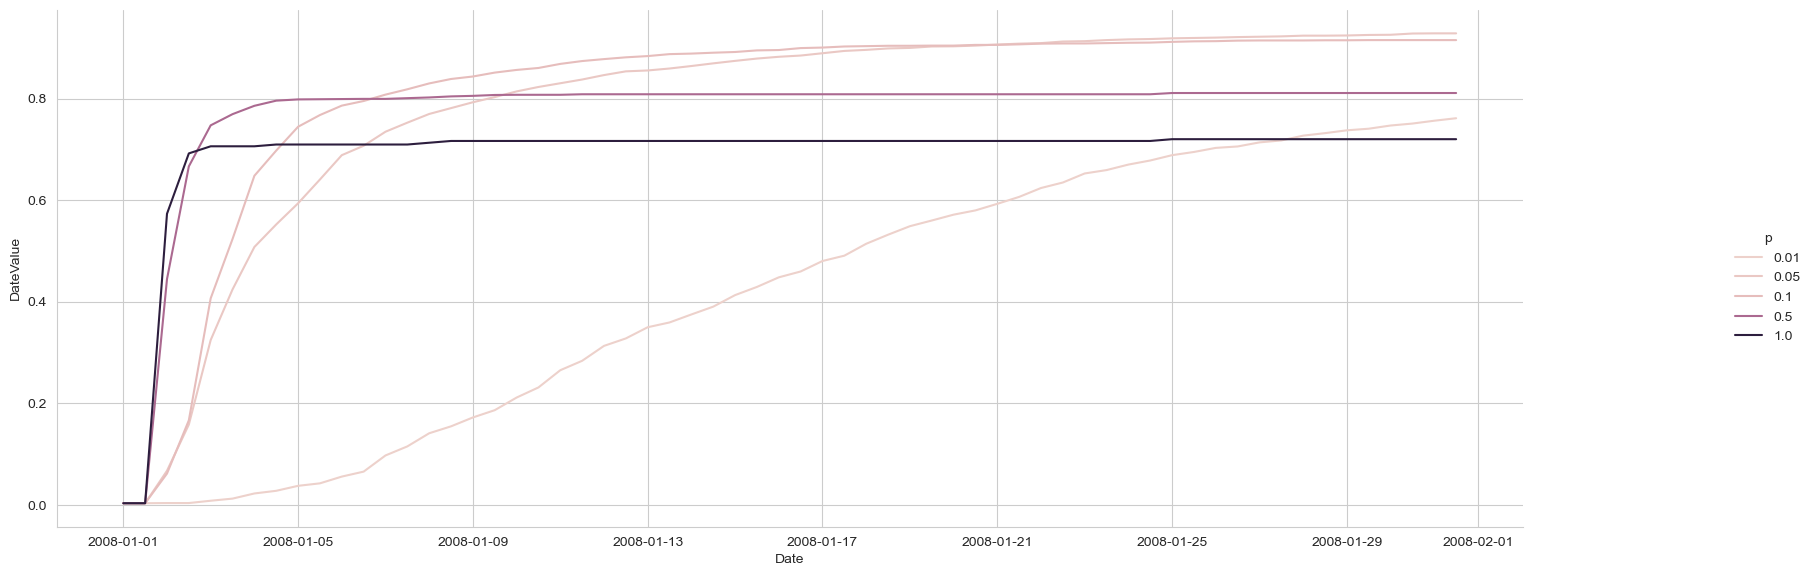

In [91]:
sns.set_style('whitegrid')
lp = sns.relplot(data=inf_percent_df, kind='line', x='Date', y='DateValue', hue='p')
lp.fig.set_figwidth(20)
lp.fig.set_figheight(6)

# Строим граф

In [92]:
data_prep.head()

,departure,origin,arrival,dst
546722,2008-01-01 05:35:00+00:00,MCO,2008-01-01 08:20:00+00:00,SJU
573205,2008-01-01 07:00:00+00:00,SJU,2008-01-01 11:07:00+00:00,EWR
546834,2008-01-01 07:25:00+00:00,SJU,2008-01-01 11:23:00+00:00,JFK
588019,2008-01-01 07:25:00+00:00,PHX,2008-01-01 12:09:00+00:00,JFK
588977,2008-01-01 07:45:00+00:00,PHX,2008-01-01 11:12:00+00:00,ATL


In [93]:
data_prep['min_arp'] = data_prep[['origin','dst']].min(axis=1)
data_prep['max_arp'] = data_prep[['origin','dst']].max(axis=1)
data_prep.head()

C:\Users\Asus\AppData\Local\Temp\ipykernel_1476\2821599130.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_prep['min_arp'] = data_prep[['origin','dst']].min(axis=1)
C:\Users\Asus\AppData\Local\Temp\ipykernel_1476\2821599130.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_prep['max_arp'] = data_prep[['origin','dst']].max(axis=1)


,departure,origin,arrival,dst,min_arp,max_arp
546722,2008-01-01 05:35:00+00:00,MCO,2008-01-01 08:20:00+00:00,SJU,MCO,SJU
573205,2008-01-01 07:00:00+00:00,SJU,2008-01-01 11:07:00+00:00,EWR,EWR,SJU
546834,2008-01-01 07:25:00+00:00,SJU,2008-01-01 11:23:00+00:00,JFK,JFK,SJU
588019,2008-01-01 07:25:00+00:00,PHX,2008-01-01 12:09:00+00:00,JFK,JFK,PHX
588977,2008-01-01 07:45:00+00:00,PHX,2008-01-01 11:12:00+00:00,ATL,ATL,PHX


In [99]:
N = data_prep.shape[0]
graph_data = data_prep.groupby(['min_arp', 'max_arp']).size()/N
graph_data = graph_data.reset_index()
graph_data.columns = ['node1', 'node2', 'weight']
graph_data.head()

,node1,node2,weight
0,ABE,ATL,0.000256
1,ABE,CLE,0.000249
2,ABE,CLT,0.000102
3,ABE,CVG,0.000087
4,ABE,DTW,0.000281


In [103]:
graph_data.to_csv('edgelist.csv', header=False, index=False, sep=' ')
ag = nx.read_weighted_edgelist('edgelist.csv', nodetype=str)
print(ag.number_of_nodes(), 'nodes and ', ag.number_of_edges(), 'edges in the graph')

287 nodes and  2386 edges in the graph


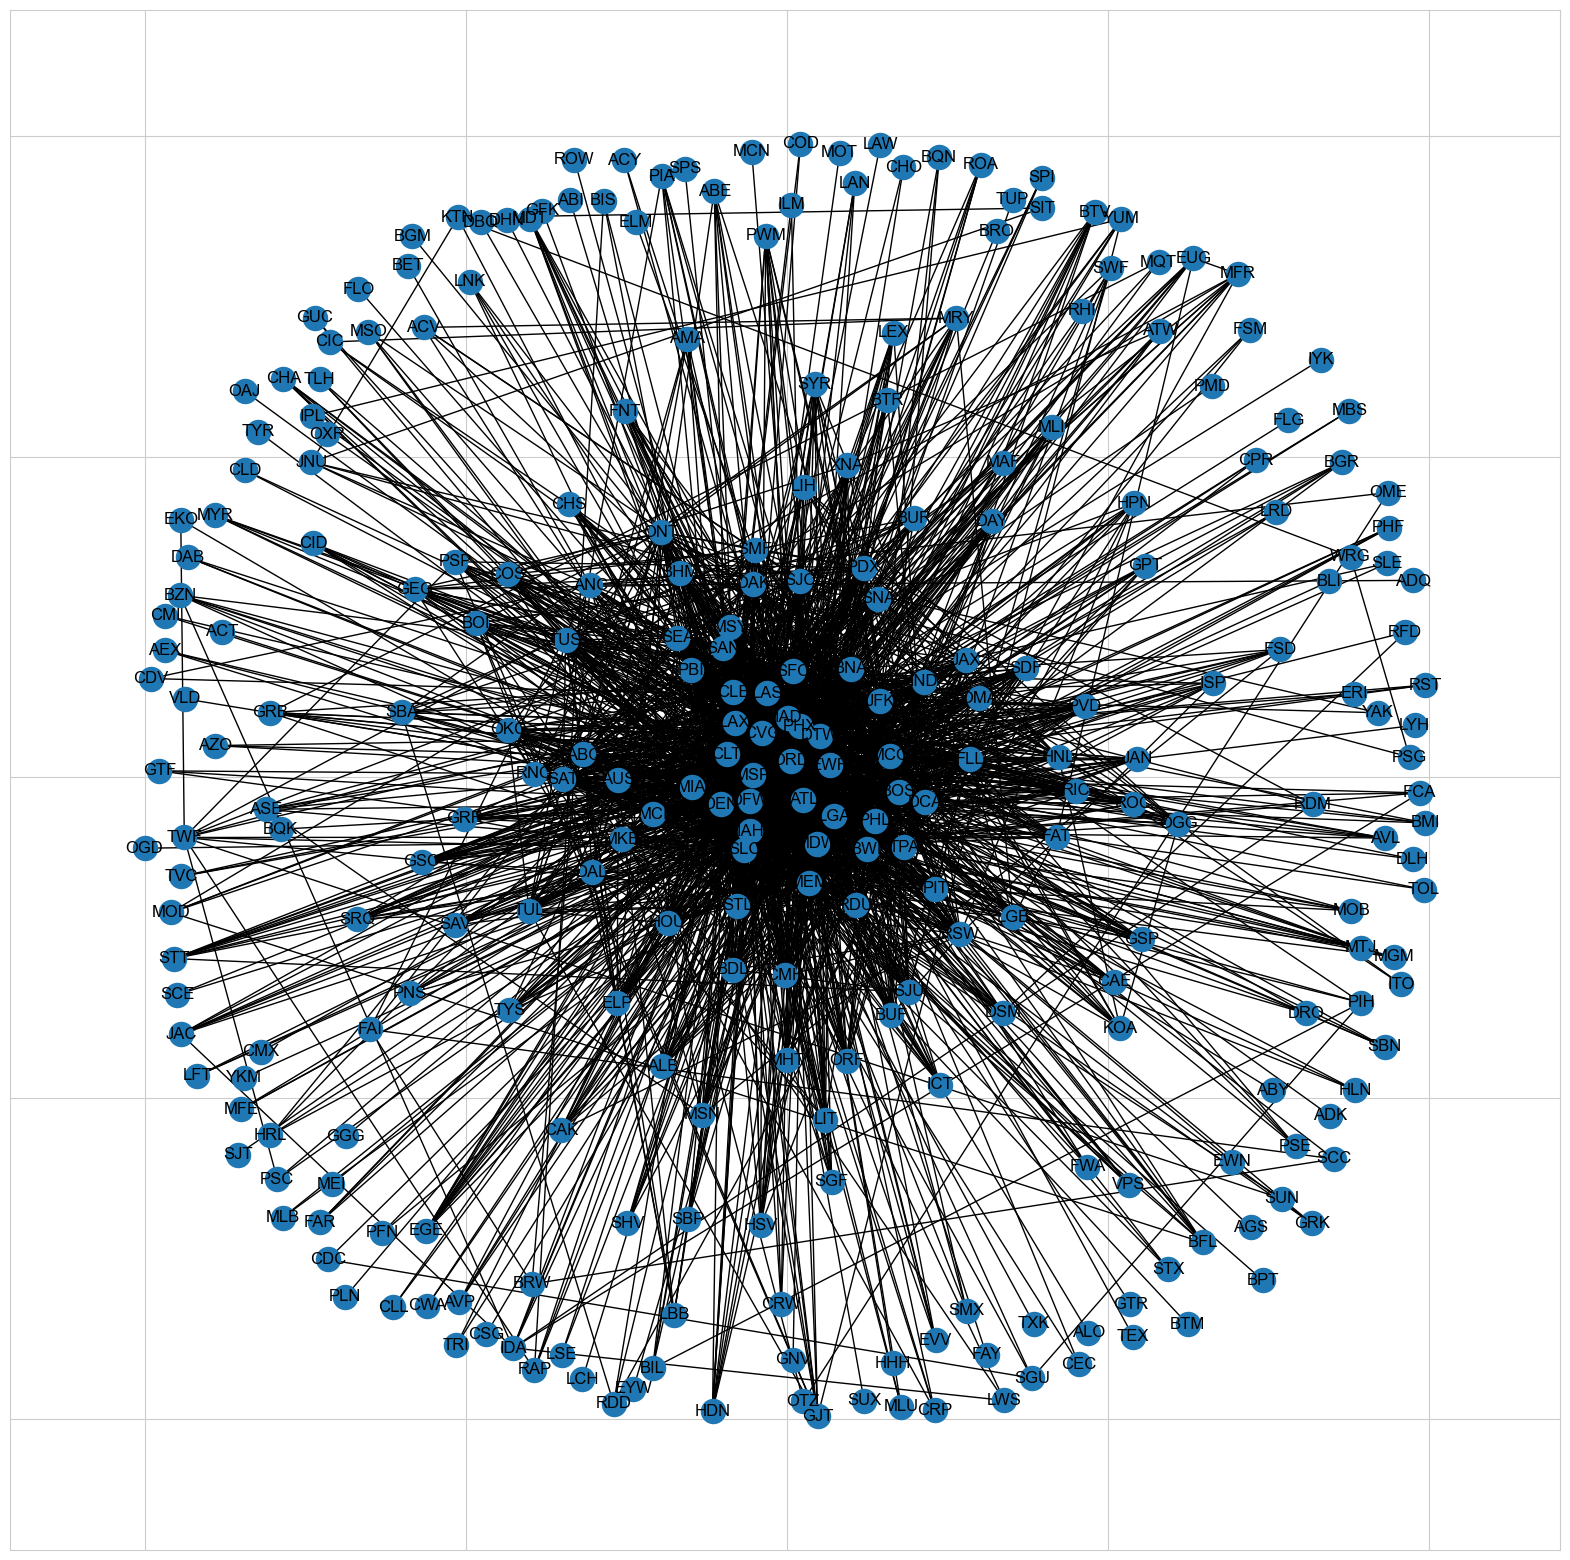

In [104]:
fig = plt.figure(1, figsize=(20, 20))
nx.draw_networkx(ag)

## Модианное время заражения для каждого города

In [108]:
p=0.5
n_sim = 50
start_airport = 'ABE'
result = pd.DataFrame()
initial_dt = to_datetime([2008], [1], [1], ['00:00'], [pytz.utc])[0]

for i in range(n_sim):
    print(f'i={i}')
    res = transform_dict_to_df(infect(p, start_airport, data_prep))
    res['try'] = i
    result = pd.concat([result,res], ignore_index = True)
    
result.head()

i=0
i=1
i=2
i=3
i=4
i=5
i=6
i=7
i=8
i=9
i=10
i=11
i=12
i=13
i=14
i=15
i=16
i=17
i=18
i=19
i=20
i=21
i=22
i=23
i=24
i=25
i=26
i=27
i=28
i=29
i=30
i=31
i=32
i=33
i=34
i=35
i=36
i=37
i=38
i=39
i=40
i=41
i=42
i=43
i=44
i=45
i=46
i=47
i=48
i=49


,Date,DateValue,try
0,2008-01-01 00:00:00+00:00,ABE,0
1,2008-01-01 12:55:00+00:00,DTW,0
2,2008-01-01 14:34:00+00:00,ORD,0
3,2008-01-01 15:09:00+00:00,ATL,0
4,2008-01-01 16:15:00+00:00,DFW,0


In [109]:
result['tot_hour_diff'] = (result['Date'] - initial_dt) / pd.Timedelta(hours=1)
result.head()

,Date,DateValue,try,tot_hour_diff
0,2008-01-01 00:00:00+00:00,ABE,0,0.000000
1,2008-01-01 12:55:00+00:00,DTW,0,12.916667
2,2008-01-01 14:34:00+00:00,ORD,0,14.566667
3,2008-01-01 15:09:00+00:00,ATL,0,15.150000
4,2008-01-01 16:15:00+00:00,DFW,0,16.250000


In [111]:
median_infectuion_time = result[['DateValue', 'tot_hour_diff']].groupby('DateValue').median().reset_index()
median_infectuion_time.columns = ['airport', 'median_infection_time_in_hours']
median_infectuion_time.head()

,airport,median_infection_time_in_hours
0,ABE,0.000000
1,ABI,23.166667
2,ABQ,20.200000
3,ABY,39.533333
4,ACT,21.208333


## Метрики из графа

In [113]:
clustering = nx.clustering(ag, weight='weight')
degree = dict(ag.degree(weight='weight'))
centrality = nx.betweenness_centrality(ag, weight='weight')
node_metrics = pd.DataFrame.from_dict(clustering ,orient='index', columns=['clustering']).join([
    pd.DataFrame.from_dict(degree ,orient='index', columns=['degree']),
    pd.DataFrame.from_dict(centrality ,orient='index', columns=['centrality'])
])
node_metrics = node_metrics.reset_index()
node_metrics.columns = ['airport', 'clustering', 'degree','centrality']

In [114]:
node_metrics.head()

,airport,clustering,degree,centrality
0,ABE,0.049903,0.001369,0.030038
1,ATL,0.020639,0.111903,0.294933
2,CLE,0.038519,0.017378,0.046807
3,CLT,0.050053,0.035487,0.090666
4,CVG,0.025043,0.028605,0.064949


In [115]:
total_node_metrics = node_metrics.merge(median_infectuion_time, on = 'airport')
total_node_metrics.head()

,airport,clustering,degree,centrality,median_infection_time_in_hours
0,ABE,0.049903,0.001369,0.030038,0.000000
1,ATL,0.020639,0.111903,0.294933,17.133333
2,CLE,0.038519,0.017378,0.046807,18.216667
3,CLT,0.050053,0.035487,0.090666,16.750000
4,CVG,0.025043,0.028605,0.064949,17.416667


<Axes: xlabel='median_infection_time_in_hours', ylabel='centrality'>

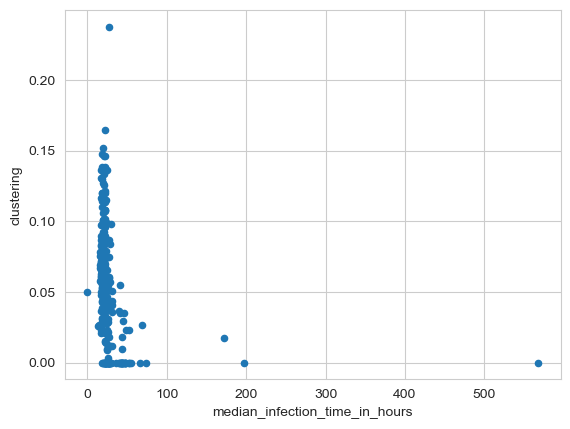

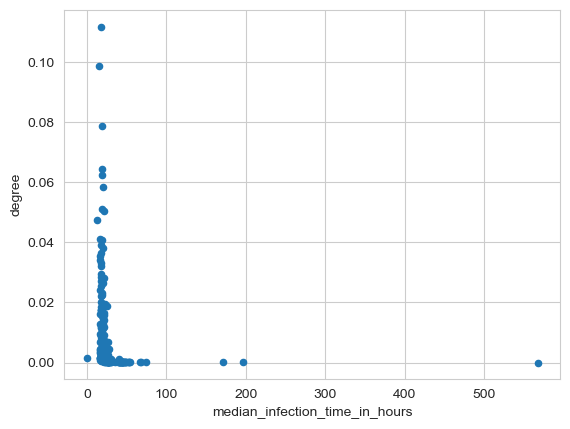

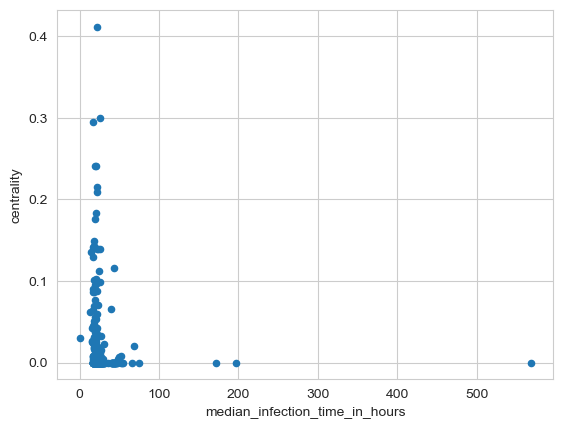

In [117]:
total_node_metrics.plot.scatter(x='median_infection_time_in_hours', y='clustering')
total_node_metrics.plot.scatter(x='median_infection_time_in_hours', y='degree')
total_node_metrics.plot.scatter(x='median_infection_time_in_hours', y='centrality')

In [120]:
total_node_metrics[['clustering', 'degree','centrality','median_infection_time_in_hours']].corr(method='spearman')

,clustering,degree,centrality,median_infection_time_in_hours
clustering,1.000000,0.457665,-0.104378,-0.515462
degree,0.457665,1.000000,0.544605,-0.773726
centrality,-0.104378,0.544605,1.000000,-0.315790
median_infection_time_in_hours,-0.515462,-0.773726,-0.315790,1.000000


Более всего медианное время заражения отрицательно скоррелировано с degree, потомы что чем больше соседей, тем более вероятно заражение.